In [2]:
#Instalamos las librerias necesarias para tener el ambiente listo para correr todo el procesamiento de datos.
!pip install pandas
!pip install metapy
!pip install pyspark
!pip install nltk
!pip install boto3
!pip install sklearn
!pip install matplotlib
!pip install TextBlob
!pip install numpy

## Analisis descriptivo y analisis de sentimientos

In [3]:
# Importamos librerias requeridas para trabajar en el notebook
import pandas as pd
import metapy
import boto3
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Importamos diccionarios y librerias de NLTK para el proceso de tokenizacion, limpieza de datos e indexacion.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hadoop/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lectura de datos desde S3

In [5]:
# Recuperamos base de datos del Bucket=finaltext desde S3 a traves de libreria boto3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='finaltext', Key='news.csv')
df = pd.read_csv(obj['Body'])

In [6]:
#imprimimos muestra de la informacion
df.head()

,id,id_news,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 10 columns):
id             142570 non-null int64
id_news        142570 non-null int64
title          142568 non-null object
publication    142570 non-null object
author         126694 non-null object
date           139929 non-null object
year           139929 non-null float64
month          139929 non-null float64
url            85559 non-null object
content        142570 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 10.9+ MB


In [8]:
newdf= df.iloc[0:1000,9]
df2 = pd.DataFrame(newdf)
df2.head()

,content
0,WASHINGTON — Congressional Republicans have...
1,"After the bullet shells get counted, the blood..."
2,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,"Death may be the great equalizer, but it isn’t..."
4,"SEOUL, South Korea — North Korea’s leader, ..."


In [9]:
df.publication.unique()

array(['New York Times', 'Breitbart', 'CNN', 'Business Insider',
       'Atlantic', 'Fox News', 'Talking Points Memo', 'Buzzfeed News',
       'National Review', 'New York Post', 'Guardian', 'NPR', 'Reuters',
       'Vox', 'Washington Post'], dtype=object)

In [10]:
df.author.unique()

array(['Carl Hulse', 'Benjamin Mueller and Al Baker', 'Margalit Fox', ...,
       'Robert Greenstein', 'Judy Mollen Walters', 'John Yearwood'],
      dtype=object)

In [11]:
df3 = df.groupby('publication')['id'].nunique()
print('numero de diarios',df3.shape[0])
df3

numero de diarios 15


publication
Atlantic                7179
Breitbart              23781
Business Insider        6757
Buzzfeed News           4854
CNN                    11488
Fox News                4354
Guardian                8681
NPR                    11992
National Review         6203
New York Post          17493
New York Times          7803
Reuters                10710
Talking Points Memo     5214
Vox                     4947
Washington Post        11114
Name: id, dtype: int64

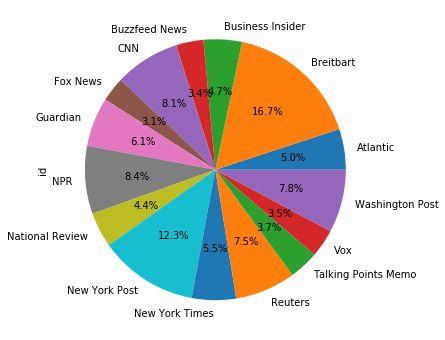

In [12]:
df3.plot.pie(figsize=(6, 6),autopct='%1.1f%%')

In [13]:
df4 = df.groupby('author')['id'].nunique()
print('numero de autores',df4.shape[0])

numero de autores 15647


### Limpieza de datos - Tokenizacion - Stemming - Lematizacion - Stop Words

In [14]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer

wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() # instancia una forma de stemming
# llamamos al diccionario de stop words en ingles
sw = stopwords.words("english")

In [15]:
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
import re
stop_words_nltk = set(stopwords.words('english'))
lancaster = LancasterStemmer()

textclean=[]
contador = 0
for document in df2['content']:
    line_clean = ""    
    tokens = nltk.word_tokenize(str(document))
    tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [wordnet_lemmatizer.lemmatize(lancaster.stem(w)) for w in tokens if len(w)>1 and w.isalpha() and w not in stop_words_nltk]
    #for w in tokens:
    #    line_clean=line_clean+w+" "
    textclean.append(" ".join(tokens))
    contador+=1

        
df2[1]=textclean #almacena vector de documentos limpios

#utilizamos libreria de Sklearn para text encoding o vectorizacion
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = None)

Infodoc = CountVectorizer().fit(df2[1])
bag_of_words = Infodoc.transform(df2[1])
Vacabulary=list(Infodoc.vocabulary_.keys())

print( "9.7 Luego de aplicar LancasterStemmer de NLTK quedan "+str(len(Vacabulary))+" tokens.")
df2.head()


9.7 Luego de aplicar LancasterStemmer de NLTK quedan 20282 tokens.


,content,1
0,WASHINGTON — Congressional Republicans have...,washington congress republ new fear com heal c...
1,"After the bullet shells get counted, the blood...",aft bullet shel get count blood dri vot candl ...
2,"When Walt Disney’s “Bambi” opened in 1942, cri...",when walt disney bamb op crit pra spar haunt v...
3,"Death may be the great equalizer, but it isn’t...",dea may gre eq necess evenhand of field endeav...
4,"SEOUL, South Korea — North Korea’s leader, ...",seo sou kore nor kore lead kim said sunday cou...


In [16]:
# Realice un TF (Term Frecuency) por cada una de las palabras del conjunto de datos final.
Infodoc = CountVectorizer().fit(df2[1])
Vacabulary=list(Infodoc.vocabulary_.keys())
bag_of_words = Infodoc.transform(df2[1])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in Infodoc.vocabulary_.items()]

words_freq[0:10]

[('washington', 783),
 ('congress', 518),
 ('republ', 1096),
 ('new', 3727),
 ('fear', 254),
 ('com', 1429),
 ('heal', 698),
 ('car', 1169),
 ('lawsuit', 150),
 ('obam', 976)]

In [17]:
#imprima el top-20 descendiente de las palabras más frecuentes en el BoW.
print("8.3 ordenamos los datos en orden descendente y mostramos las 20 palabras de mayor TF en el BoW")
pd.set_option('display.max_rows', 100)
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
df3=pd.DataFrame(words_freq,columns=['Word', 'TF'])
df3.head(10)

8.3 ordenamos los datos en orden descendente y mostramos las 20 palabras de mayor TF en el BoW


,Word,TF
0,mr,10592
1,said,9134
2,the,7531
3,trump,5056
4,new,3727
5,on,3597
6,stat,3531
7,would,2909
8,year,2883
9,presid,2820


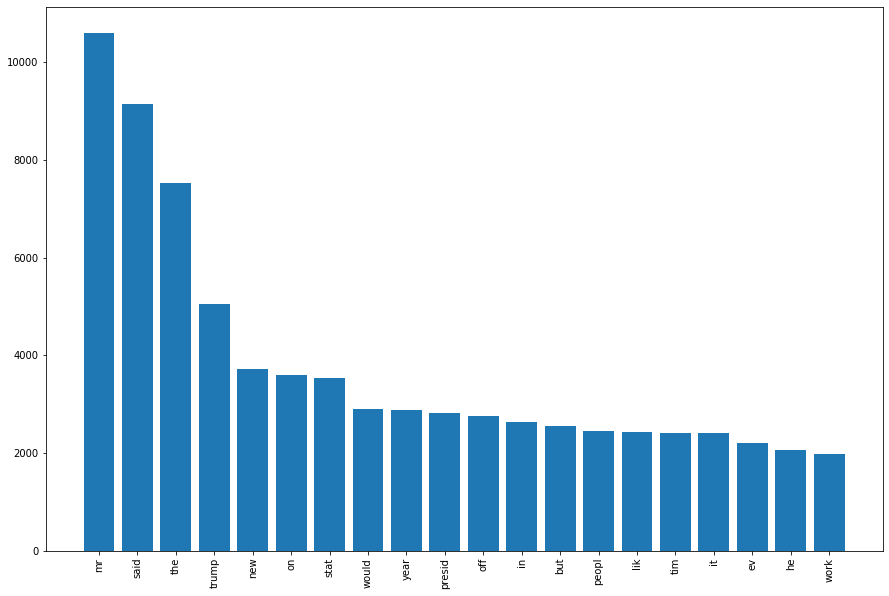

In [18]:
# Realice la grafica de barras en matplotlib de estas 20 palabras en orden descendentes.
plt.figure(figsize=(15,10))
plt.bar(df3['Word'][:20],df3['TF'][:20])
plt.xticks(rotation=90)
plt.show()

In [19]:
from textblob import TextBlob

In [20]:
def sentiment_func(lyrics):
    try:
        return TextBlob(lyrics).polarity
    except:
        return None

In [21]:
df2['polaridad'] = df2[df2.columns[1]].apply(sentiment_func)

In [22]:
df2['Sentimientos'] = np.where(df2['polaridad']>0,'pos','neg')
df2.head()

,content,1,polaridad,Sentimientos
0,WASHINGTON — Congressional Republicans have...,washington congress republ new fear com heal c...,0.187275,pos
1,"After the bullet shells get counted, the blood...",aft bullet shel get count blood dri vot candl ...,-0.046867,neg
2,"When Walt Disney’s “Bambi” opened in 1942, cri...",when walt disney bamb op crit pra spar haunt v...,0.014059,pos
3,"Death may be the great equalizer, but it isn’t...",dea may gre eq necess evenhand of field endeav...,0.062556,pos
4,"SEOUL, South Korea — North Korea’s leader, ...",seo sou kore nor kore lead kim said sunday cou...,0.138755,pos


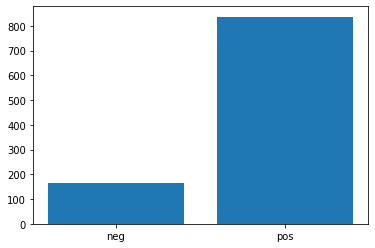

In [23]:
import numpy as np
labels, counts = np.unique(df2['Sentimientos'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [24]:
ls=df2.iloc[:,[1,3]].values.tolist()

In [25]:
df4=[]
#for document in df2['description']: 
for document,c in ls:  
    tokens = str(document).split()
    tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w.lower() for w in tokens if len(w)>1]
    df4.append((tokens,c)) #almacena vector de documentos limpios

In [26]:
labeled=[]
for document,c in df4:
    for word in document:
        labeled.append(word)
len(labeled)

640459

In [27]:
all_words = nltk.FreqDist(w.lower() for w in labeled)
word_features = list(all_words)
len(all_words)

20282

In [28]:
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [29]:
featuresets = [(document_features(d), c) for (d,c) in df4]
train_set, test_set = featuresets[100:], featuresets[:100]

classifier = nltk.NaiveBayesClassifier.train(train_set)

In [30]:
print(nltk.classify.accuracy(classifier, test_set))

0.78


In [66]:
classifier.show_most_informative_features(10)

Most Informative Features
       contains(broward) = True              neg : pos    =     15.4 : 1.0
          contains(orph) = True              neg : pos    =     15.4 : 1.0
           contains(kab) = True              neg : pos    =     15.4 : 1.0
         contains(blist) = True              neg : pos    =     15.4 : 1.0
         contains(ahmad) = True              neg : pos    =     15.4 : 1.0
        contains(sheikh) = True              neg : pos    =     13.4 : 1.0
          contains(meag) = True              neg : pos    =     12.0 : 1.0
         contains(farah) = True              neg : pos    =     12.0 : 1.0
         contains(extol) = True              neg : pos    =     12.0 : 1.0
          contains(drip) = True              neg : pos    =     12.0 : 1.0


In [58]:
test_sentence = "congress broward orph blist ahmad sheikh meag drip eclips kandah dun infury"
print(test_sentence)

congress broward orph blist ahmad sheikh meag drip eclips kandah dun infury


In [59]:
tokens2 = test_sentence.split()
tokens2 = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens2]
tokens2 = [w for w in tokens2 if w.isalpha()]
tokens2 = [w.lower() for w in tokens2 if len(w)>1]

tokens2

['congress',
 'broward',
 'orph',
 'blist',
 'ahmad',
 'sheikh',
 'meag',
 'drip',
 'eclips',
 'kandah',
 'dun',
 'infury']

In [60]:
featuresets2 = [document_features(tokens2)]
featuresets2

[{'contains(washington)': False,
  'contains(congress)': True,
  'contains(republ)': False,
  'contains(new)': False,
  'contains(fear)': False,
  'contains(com)': False,
  'contains(heal)': False,
  'contains(car)': False,
  'contains(lawsuit)': False,
  'contains(obam)': False,
  'contains(admin)': False,
  'contains(they)': False,
  'contains(might)': False,
  'contains(win)': False,
  'contains(the)': False,
  'contains(incom)': False,
  'contains(trump)': False,
  'contains(could)': False,
  'contains(choos)': False,
  'contains(long)': False,
  'contains(defend)': False,
  'contains(execut)': False,
  'contains(branch)': False,
  'contains(suit)': False,
  'contains(challeng)': False,
  'contains(auth)': False,
  'contains(spend)': False,
  'contains(bil)': False,
  'contains(doll)': False,
  'contains(in)': False,
  'contains(subsidy)': False,
  'contains(am)': False,
  'contains(hand)': False,
  'contains(hous)': False,
  'contains(big)': False,
  'contains(vict)': False,
  'co

In [61]:
print('la noticia es: ',classifier.classify(featuresets2[0]))

la noticia es:  neg
